# Reflecting Cosmic Ray analysis
This notebook analyzes pairs of tracks from simulated cosmic ray events, comparing upstream and downstream properties to extract the momentum resolution and shift due to material effects.
It uses root, uproot, and standard python numerical and plotting packages.

In [36]:
import os
import uproot 
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
#import tensorflow as tf
#from pathlib import Path
print("Hello world")

Hello world


This notebook processes TrkAna files constructed using the SelectReflections_module filter.
The TrkAna files contain 4 trees, one for each particle type reconstruction assumption: e+, e-, mu+, and mu-.
Each tree has the same structure, consisting of 2 tracks reconstructed from this particle: trk[0] is the upstream-going fit, trk[1] is the downstream-going fit.

In [69]:
input_dataset = np.empty
temp = np.empty
signal = np.empty
backgnd = np.empty
#files = ["/global/cfs/cdirs/m3712/Mu2e/TARef_v7.root:TARmuM/trkana"]
files = ["/Users/brownd/data/14356147/nts.brownd.TAReflect.TARef.001202_00004963.root:TARmuM/trkana",
         "/Users/brownd/data/14356147/nts.brownd.TAReflect.TARef.001202_00015026.root:TARmuM/trkana",
        "/Users/brownd/data/14356147/nts.brownd.TAReflect.TARef.001202_00005432.root:TARmuM/trkana",
        "/Users/brownd/data/14356147/nts.brownd.TAReflect.TARef.001202_00000000.root:TARmuM/trkana",
        "/Users/brownd/data/14356147/nts.brownd.TAReflect.TARef.001202_00000010.root:TARmuM/trkana",
        "/Users/brownd/data/14356147/nts.brownd.TAReflect.TARef.001202_00000085.root:TARmuM/trkana",
        "/Users/brownd/data/14356147/nts.brownd.TAReflect.TARef.001202_00010872.root:TARmuM/trkana",
        "/Users/brownd/data/14356147/nts.brownd.TAReflect.TARef.001202_00000053.root:TARmuM/trkana",
        "/Users/brownd/data/14356147/nts.brownd.TAReflect.TARef.001202_00000024.root:TARmuM/trkana",
        "/Users/brownd/data/14356147/nts.brownd.TAReflect.TARef.001202_00010057.root:TARmuM/trkana"]
    
#time = []
up_up_time = []
up_down_time = []
down_down_time = []
upmcpdg = []
downmcpdg = []
up_px = []
up_py = []
up_pz = []
down_px = []
down_py = []
down_pz = []

up_posx = []
up_posy = []
down_posx = []
down_posy = []

nipa_up = []
nipa_down = []
nst_up = []
nst_down = []
for batch,rep in uproot.iterate(files,filter_name="/trk|trkfit|trkmcsim/i",report=True):
    print("Fields available in 'trkfit':", ak.fields(batch["trkfit"]))
    # upstream and downstream tracks
    upstream = batch["trkfit"][:,0]
    downstream = batch["trkfit"][:,1]
    print("uspstream ",len(upstream)," downstream ",len(downstream))
    uptrkmcsim = batch["trkmcsim"][:,0][:,0] # primary MC particle matched to the upstream track
    downtrkmcsim = batch["trkmcsim"][:,1][:,0] # primary MC particle matched to the downstream track
    # find the samples at the tracker entrance
    up_up = (upstream["sid"] == 0) & (upstream['mom']['fCoordinates']['fZ'] < 0) # exiting the tracker
    up_down = (upstream["sid"] == 0) & (upstream['mom']['fCoordinates']['fZ'] > 0) # re-entering the tracker
    down_down = (downstream["sid"] == 0) & (downstream['mom']['fCoordinates']['fZ'] > 0) # entering the tracker
    has_up_up = ak.sum(up_up,axis=1) > 0
    has_up_down = ak.sum(up_down,axis=1) > 0
    has_down_down = ak.sum(down_down,axis=1) > 0
    has_all = has_up_up & has_up_down & has_down_down
    up_up = up_up[has_all]
    up_down = up_down[has_all]
    down_down = down_down[has_all]
    up_up_time.extend(ak.flatten(upstream[has_all][up_up]['time']))                      
    up_down_time.extend(ak.flatten(upstream[has_all][up_down]['time']))
    down_down_time.extend(ak.flatten(downstream[has_all][down_down]['time']))
    uptrkmcsim = uptrkmcsim[has_all]
    downtrkmcsim = downtrkmcsim[has_all]
    upmcpdg.extend(uptrkmcsim['pdg'])
    downmcpdg.extend(downtrkmcsim['pdg'])
    up_px.extend(ak.flatten(upstream[has_all][up_down]['mom']['fCoordinates']['fX']))
    up_py.extend(ak.flatten(upstream[has_all][up_down]['mom']['fCoordinates']['fY']))
    up_pz.extend(ak.flatten(upstream[has_all][up_down]['mom']['fCoordinates']['fZ']))
    down_px.extend(ak.flatten(downstream[has_all][down_down]['mom']['fCoordinates']['fX']))
    down_py.extend(ak.flatten(downstream[has_all][down_down]['mom']['fCoordinates']['fY']))
    down_pz.extend(ak.flatten(downstream[has_all][down_down]['mom']['fCoordinates']['fZ']))

    up_posx.extend(ak.flatten(upstream[has_all][up_down]['pos']['fCoordinates']['fX']))
    up_posy.extend(ak.flatten(upstream[has_all][up_down]['pos']['fCoordinates']['fY']))
    down_posx.extend(ak.flatten(downstream[has_all][down_down]['pos']['fCoordinates']['fX']))
    down_posy.extend(ak.flatten(downstream[has_all][down_down]['pos']['fCoordinates']['fY']))
    
    nipaup = batch["trk.nipaup"][:,0] # only need upstream track for material intersection counting
    nipadown = batch["trk.nipadown"][:,0]
    nstup = batch["trk.nstup"][:,0]
    nstdown = batch["trk.nstdown"][:,0]
    nipaup = nipaup[has_all]
    nipadown = nipadown[has_all]
    nstup = nstup[has_all]
    nstdown = nstdown[has_all]
    
    nipa_up.extend(nipaup)
    nipa_down.extend(nipadown)
    nst_up.extend(nstup)    
    nst_down.extend(nstdown)

deltapdg = np.subtract(upmcpdg,downmcpdg)
decay = []
for dpdg in deltapdg :
    decay.append(dpdg != 0)
decay = np.array(decay)

#print("NIPA_up",len(nipa_up),nipa_up[:10])

up_mom2 = np.square(up_px) + np.square(up_py) + np.square(up_pz)
up_mom = np.sqrt(up_mom2)
down_mom2 = np.square(down_px) + np.square(down_py) + np.square(down_pz)
down_mom = np.sqrt(down_mom2)

up_posx = np.array(up_posx)
up_posy = np.array(up_posy)
down_posx = np.array(down_posx)
down_posy = np.array(down_posy)

nipa = np.add(nipa_up,nipa_down)
nst = np.add(nst_up,nst_down)
nmat = np.add(nipa,nst)

print("Upstream momentum ",len(up_mom),up_mom[:10])
print("Downstream momentum ",len(down_mom),down_mom[:10])
print("Upstream fit upstream time ",len(up_up_time),up_up_time[:10])
print("Upstream fit downstream time",len(up_down_time),up_down_time[:10])
print("Downstream fit downstream time",len(down_down_time),down_down_time[:10])
print("Upstream MC PDG code",len(upmcpdg),upmcpdg[:10])
print("Downstream MC PDG code",len(downmcpdg),downmcpdg[:10])
print("Decays ",decay.sum())
print("nmat ",len(nmat))
print("N ST ",nst[:10]," N IPA ",nipa[:10], "N mat ", nmat[:10])

Fields available in 'trkfit': ['mom', 'pos', 'time', 'dmom', 'momerr', 'inbounds', 'gap', 'early', 'late', 'sid', 'sindex']
uspstream  3092  downstream  3092
Fields available in 'trkfit': ['mom', 'pos', 'time', 'dmom', 'momerr', 'inbounds', 'gap', 'early', 'late', 'sid', 'sindex']
uspstream  1554  downstream  1554
Fields available in 'trkfit': ['mom', 'pos', 'time', 'dmom', 'momerr', 'inbounds', 'gap', 'early', 'late', 'sid', 'sindex']
uspstream  3092  downstream  3092
Fields available in 'trkfit': ['mom', 'pos', 'time', 'dmom', 'momerr', 'inbounds', 'gap', 'early', 'late', 'sid', 'sindex']
uspstream  946  downstream  946
Fields available in 'trkfit': ['mom', 'pos', 'time', 'dmom', 'momerr', 'inbounds', 'gap', 'early', 'late', 'sid', 'sindex']
uspstream  3098  downstream  3098
Fields available in 'trkfit': ['mom', 'pos', 'time', 'dmom', 'momerr', 'inbounds', 'gap', 'early', 'late', 'sid', 'sindex']
uspstream  1119  downstream  1119
Fields available in 'trkfit': ['mom', 'pos', 'time', '

Label true elec

In [70]:
true_em = []
true_mum = []
for mcpdg in upmcpdg :
    true_em.append(mcpdg == 11)
    true_mum.append(mcpdg == 13)
true_em = np.array(true_em)
true_mum = np.array(true_mum)
print("True Electrons",len(true_em),true_em[:10])
print("True Muons",len(true_mum),true_mum[:10])


True Electrons 42345 [False  True False False False False False False False False]
True Muons 42345 [ True False  True  True  True  True  True  True  True  True]


42345 42345
N true electrons  1243  N true muons  41092


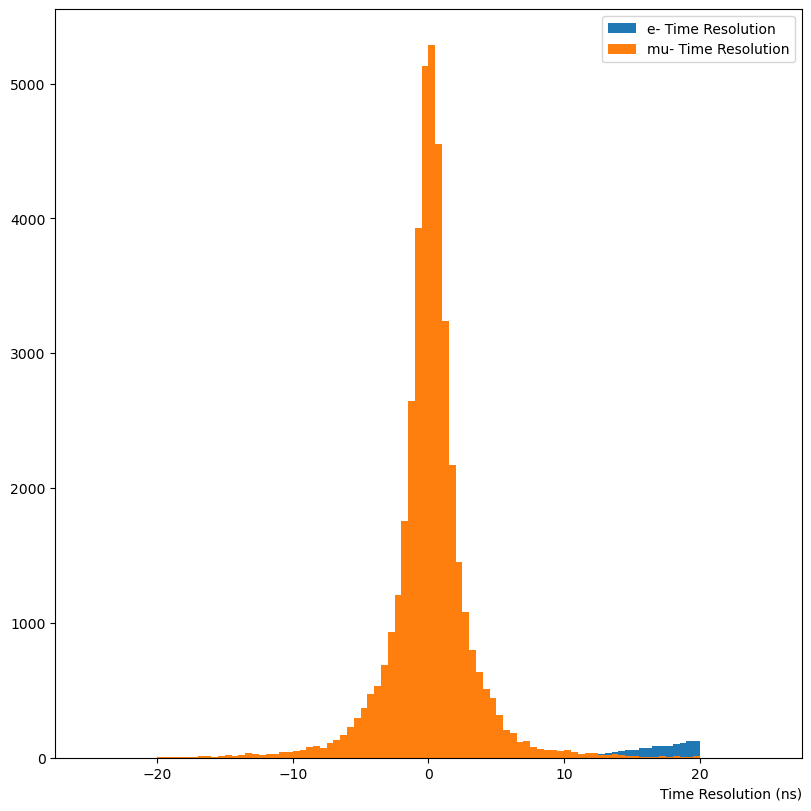

In [71]:
print(len(up_down_time),len(down_down_time))
time_diff = np.subtract(up_down_time,down_down_time)
em_time_diff = time_diff[true_em]
mum_time_diff = time_diff[true_mum]
print("N true electrons ",len(em_time_diff), " N true muons ", len(mum_time_diff))
fig, ax = plt.subplots(layout='constrained', figsize=(8, 8))
ax.hist(em_time_diff,label="e- Time Resolution", bins=100,range=(-25,25))
ax.hist(mum_time_diff,label="mu- Time Resolution", bins=100,range=(-25,25))
ax.set_xlabel("Time Resolution (ns)",loc='right')
ax.legend()

In [72]:
abs_time_diff = np.absolute(time_diff)
good_mum = []
max_tdiff = 8.0
for tdiff in abs_time_diff :
    good_mum.append( tdiff <  max_tdiff)
print("Good muon ",len(good_mum),good_mum[:10])
good_mum = np.array(good_mum)
true_good_mum = good_mum[true_mum]
eff = good_mum.sum()/true_mum.sum()
pur = true_good_mum.sum()/good_mum.sum()
print("For Delta T < ", max_tdiff , " efficiency = ",eff," purity = ",pur)

Good muon  42345 [True, False, True, True, True, True, True, True, True, True]
For Delta T <  8.0  efficiency =  0.9698968168986664  purity =  0.9996236356793377


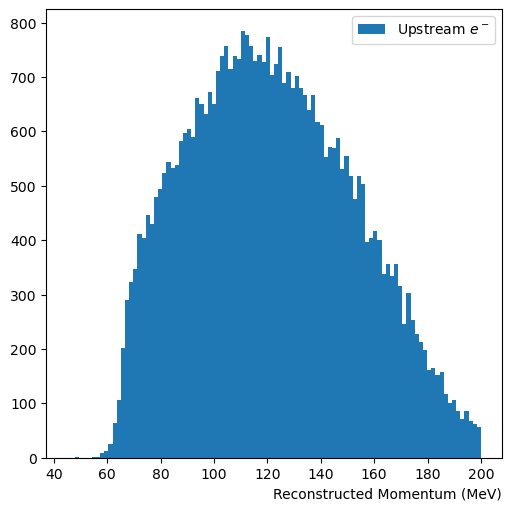

In [73]:
fig, ax = plt.subplots(layout='constrained', figsize=(5, 5))
uphist = ax.hist(up_mom,label="Upstream $e^-$", bins=100,range=(45,200))
ax.set_xlabel('Reconstructed Momentum (MeV)',loc='right')
ax.legend()

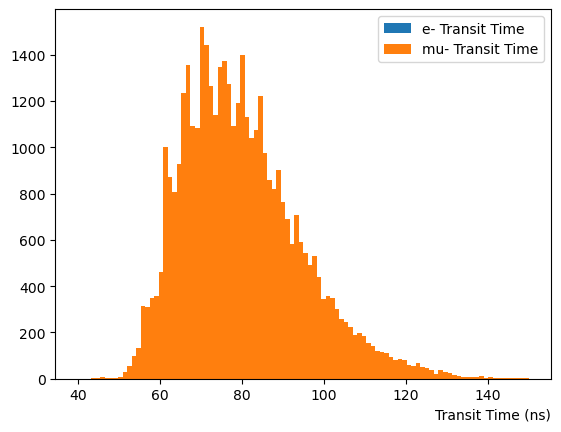

In [74]:
transit_time = np.subtract(up_down_time,up_up_time)
em_transit_time = transit_time[true_em]
mum_transit_time = transit_time[true_mum]
plt.hist(em_transit_time,label="e- Transit Time", bins=100,range=(40,150))
plt.hist(mum_transit_time,label="mu- Transit Time", bins=100,range=(40,150))
plt.xlabel('Transit Time (ns)', loc='right')
plt.legend()

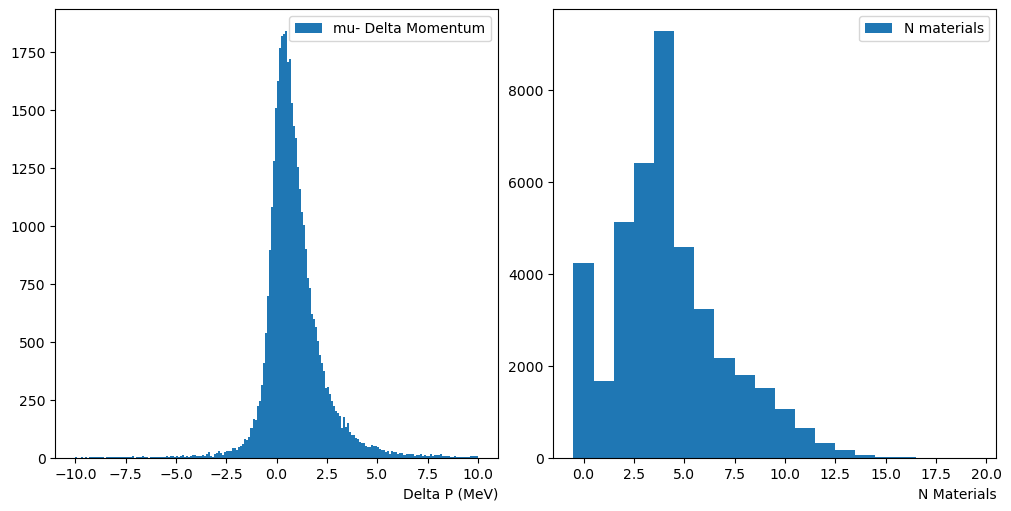

In [75]:
mom_diff = up_mom - down_mom
nomat = []
for nm in nmat :
    nomat.append( nm <1 )
nomat = np.array(nomat)
good_mum_nomat = np.logical_and(nomat,true_mum)

em_mom_diff = mom_diff[good_mum]
em_mom_diff_nomat = mom_diff[good_mum_nomat]
nmat_good = nmat[good_mum]
up_mom_good = up_mom[good_mum]
fig, (ax0, ax1 )  = plt.subplots(1,2,layout='constrained', figsize=(10,5))
dmomhist = ax0.hist(em_mom_diff,label="mu- Delta Momentum", bins=200,range=(-10,10))
ax0.set_xlabel("Delta P (MeV)",loc='right')
ax0.legend()
nmathist = ax1.hist(nmat,label="N materials",bins=20,range=(-0.5,19.5))
ax1.set_xlabel("N Materials",loc='right')
ax1.legend()

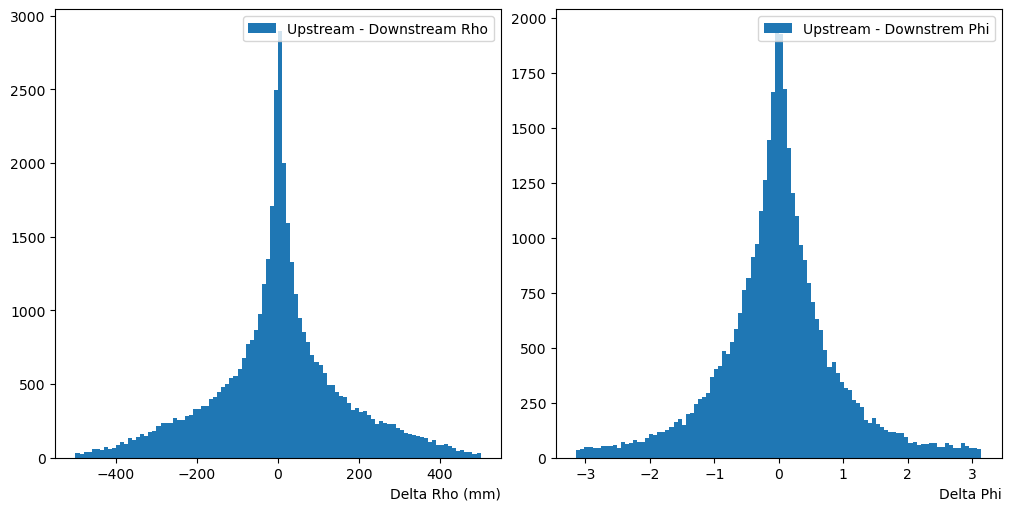

In [76]:
up_rho2 = np.square(up_posx) + np.square(up_posy)
up_rho = np.sqrt(up_rho2);
down_rho2 = np.square(down_posx) + np.square(down_posy)
down_rho = np.sqrt(down_rho2)
drho = up_rho - down_rho

up_phi = np.arctan2(up_posy, up_posx)
down_phi = np.arctan2(down_posy, down_posx)
dphi = up_phi - down_phi

fig, (ax0, ax1 )  = plt.subplots(1,2,layout='constrained', figsize=(10,5))
drho = ax0.hist(drho,label="Upstream - Downstream Rho", bins=100,range=(-500,500))
ax0.set_xlabel("Delta Rho (mm)",loc='right')
ax0.legend()
dphi = ax1.hist(dphi,label="Upstream - Downstrem Phi",bins=100,range=(-3.14,3.14))
ax1.set_xlabel("Delta Phi",loc='right')
ax1.legend()